In [217]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
import numpy as np
sonetos = np.load('sonetosSigloXIX.npy')

In [219]:
sonetos.shape

(2695,)

In [220]:
from models import replace_chars
input_text = []
target_text = []
for soneto in sonetos:
    soneto = replace_chars(soneto.lower())
    input_text.append('<sos> ' + soneto)
    target_text.append(soneto + ' <eos>')

In [221]:
input_text[2]

'<sos> y miras a jesús char_comma  virgen maría char_exclamation_close  char_new_line y latiendo tu pecho de quebranto char_new_line a mares viertes congojoso llanto char_new_line y aun brama de furor la turna impía char_exclamation_close  char_new_line  char_new_line  char_exclamation_open y goza contemplando su agonía char_comma  char_new_line y no se abate de mortal espanto char_exclamation_close  char_dot  char_dot  char_dot  char_new_line  char_exclamation_open y al ver la pena en tu semblante santo char_new_line su alma a la piedad se ostenta fría char_exclamation_close  char_new_line  char_new_line  char_question_open mas char_comma  quién char_comma   char_exclamation_open maría char_exclamation_close  brindará consuelo char_new_line a la honda angustia que en tu ser impera char_comma  char_new_line si ella cubre a la vez de luto el cielo char_question_close  char_new_line  char_new_line  char_exclamation_open y es tan ardiente y tan profunda y fiera char_comma  char_new_line q

In [222]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [223]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(input_text + target_text)

In [224]:
input_sonetos = tokenizer.texts_to_sequences(input_text)
target_sonetos = tokenizer.texts_to_sequences(target_text)

In [225]:
len(tokenizer.word_index)

24679

In [226]:
tokenizer.word_index['<eos>']

28

In [227]:
print(input_sonetos[0][:10])
print(target_sonetos[0][:10])

[27, 12122, 9, 51, 386, 277, 12123, 2, 1, 69]
[12122, 9, 51, 386, 277, 12123, 2, 1, 69, 38]


In [228]:
print(input_sonetos[0][-10:])
print(target_sonetos[0][-10:])

[25, 3827, 8, 22, 3374, 4, 2283, 3, 1, 1]
[3827, 8, 22, 3374, 4, 2283, 3, 1, 1, 28]


In [229]:
len(input_sonetos[0]), len(target_sonetos[0])

(138, 138)

In [230]:
MAX_LEN = max([len(soneto) for soneto in input_sonetos])

In [231]:
VOCAB_SIZE = len(tokenizer.word_index)

In [232]:
VOCAB_SIZE

24679

In [233]:
input_sonetos_padded = pad_sequences(input_sonetos, maxlen=MAX_LEN, padding='post')
target_sonetos_padded = pad_sequences(target_sonetos, maxlen=MAX_LEN, padding='post')

In [234]:
print(input_sonetos_padded[0][:150])
print(target_sonetos_padded[0][:150])

[   27 12122     9    51   386   277 12123     2     1    69    38  1009
    48  1196     2     5 12124     3     1   629    26  2280     2   585
     2     8   102    63  1814     2     1     9    23   175     9   686
     4   122  8226     3     1     1    35  4396     9     4    51   305
  8227     2     1     9     7   205  2719     5  2461    69  8228     1
    44     2   606 12125     2 12126    36     1    19    94  2281     9
    41  2282     2    25  8229    18     1     1   540    10   460     3
 12127     2   585   109     3     1    80  2280    23    26     2 12128
     2    32   607     3     1   276   111     2    94  8230   386    47
   282  5236     3     1     1   777     2  5237     2   257   156  5238
     2     1    44 12129 12130     2 12131     1    25  3827     8    22
  3374     4  2283     3     1     1     0     0     0     0     0     0
     0     0     0     0     0     0]
[12122     9    51   386   277 12123     2     1    69    38  1009    48
  1196     2 

In [235]:
from keras.utils import to_categorical

In [236]:
target_sonetos_padded.shape

(2695, 187)

In [237]:
NUM_SONETOS = 500

In [238]:
target_sonetos_padded_cat = to_categorical(target_sonetos_padded[:NUM_SONETOS]-1, 
                                           num_classes=VOCAB_SIZE)

In [239]:
target_sonetos_padded_cat.shape

(500, 187, 24679)

In [240]:
input_sonetos_padded.shape

(2695, 187)

In [241]:
target_sonetos_padded.shape

(2695, 187)

In [242]:
to_categorical(np.array([1, 2, 3,10])-1, num_classes = 10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [243]:
def generator(input_sonetos_padded, target_sonetos_padded, batch_size = 16):
 # Create empty arrays to contain batch of features and labels#
 batch_features = np.zeros((batch_size, 64, 64, 3))
 batch_labels = np.zeros((batch_size,1))
 while True:
    indexes = np.random.choice(len(input_sonetos_padded), batch_size, replace=False)
    batch_features = input_sonetos_padded[indexes]
    batch_labels = to_categorical(target_sonetos_padded[indexes]-1, num_classes=VOCAB_SIZE)
    yield batch_features, batch_labels

In [244]:
from DataGenerator import DataGenerator

In [245]:
gen = DataGenerator(input_sonetos_padded, target_sonetos_padded, VOCAB_SIZE, shuffle=False)
i = 0
for g in gen:
    print(g[0], g[1].shape)
    i = i+ 1
    if i == 3:
        break;

Epoch ended, reseting indexes
[[   27 12122     9 ...     0     0     0]
 [   27    48   312 ...     0     0     0]
 [   27     5  3007 ...     0     0     0]
 ...
 [   27  2293 12173 ...     0     0     0]
 [   27    35  6364 ...     0     0     0]
 [   27  6367    31 ...     0     0     0]] (16, 187, 24679)
[[   27    84    34 ...     0     0     0]
 [   27    11  1159 ...     0     0     0]
 [   27  1734  2475 ...     0     0     0]
 ...
 [   27    38   780 ...     0     0     0]
 [   27 12238    91 ...     0     0     0]
 [   27  1565     5 ...     0     0     0]] (16, 187, 24679)
[[  27 6392    7 ...    0    0    0]
 [  27 5281 6399 ...    0    0    0]
 [  27   42    8 ...    0    0    0]
 ...
 [  27   95   32 ...    0    0    0]
 [  27  892 1156 ...    0    0    0]
 [  27   23  831 ...    0    0    0]] (16, 187, 24679)


In [246]:
input_sonetos_padded[32]

array([   27,  6392,     7,  6393,  2293,     2,     7,   381,     2,
          14, 12248,     1,     9,    38,    11,  6394,  5280,     1,
          23,  8308, 12249,     6,  1062,     1,    53,  8309,    15,
       12250,     8,     7, 12251,     3,     1,     1,   781,    10,
           6,  6395,     2,     5,     7,  6396,     1,   389,   222,
           6, 12252, 12253,     2,     1,     5,     7,   381,   406,
           8,    98, 12254,     1,    35,    25,    54,    23,   284,
        1943,   144, 12255,    36,     1,     1,  1014,     6,  6394,
           9,    23,   156,     1,     7,  1483,  1961,  3413,  8310,
           2,     1,  6397,    31,  1838,     7,  2310,     8,    17,
        4429,     3,     1,     1,  2491,   381,   138,     2,   406,
           7,  6393,  2293,    12,     1,    80,    26,  1943,  3043,
        6398,  6394,     1,     4,   434,  1950,    20,    70,    14,
        3044,     3,     1,     1,     0,     0,     0,     0,     0,
           0,     0,

In [247]:
gen = generator(input_sonetos_padded, target_sonetos_padded)
for g in gen:
    print(g[0], g[1].shape)
    break;

[[   27  4423    13 ...     0     0     0]
 [   27   658     2 ...     0     0     0]
 [   27    25    54 ...     0     0     0]
 ...
 [   27    35   803 ...     0     0     0]
 [   27 20635     8 ...     0     0     0]
 [   27  2137   304 ...     0     0     0]] (16, 187, 24679)


In [248]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense

In [265]:
word_dim = 64
lstm_units = 128
model = Sequential()
model.add(Embedding(VOCAB_SIZE+1, word_dim, mask_zero = True))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(Dense(VOCAB_SIZE, activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 64)          1579520   
_________________________________________________________________
lstm_22 (LSTM)               (None, None, 128)         98816     
_________________________________________________________________
dense_22 (Dense)             (None, None, 24679)       3183591   
Total params: 4,861,927
Trainable params: 4,861,927
Non-trainable params: 0
_________________________________________________________________


In [266]:
optim = Adam(lr=0.1)

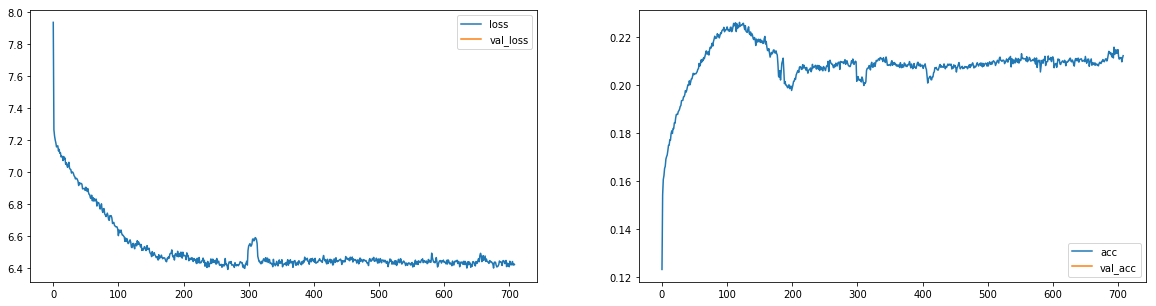

Epoch 710/2000
115/168 [===================>..........] - ETA: 21s - loss: 6.4345 - acc: 0.2105

In [ ]:
from fnn_helper import PlotLosses
batch_size = 16
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
#model.fit(input_sonetos_padded[:NUM_SONETOS], 
#          target_sonetos_padded_cat, 
#          batch_size=batch_size, epochs=200, verbose = 1, callbacks=[plot_losses])
model.fit_generator(generator(input_sonetos_padded, target_sonetos_padded, batch_size = batch_size),
                    steps_per_epoch=int(len(input_sonetos_padded)/batch_size), 
                    epochs=2000,
                    callbacks=[plot_losses])

# model.fit_generator(DataGenerator(input_sonetos_padded, target_sonetos_padded, VOCAB_SIZE, batch_size = batch_size, shuffle=False),
#                     steps_per_epoch=int(len(input_sonetos_padded)/batch_size), 
#                     epochs=2000,
#                     callbacks=[plot_losses])

In [ ]:
file_name = 'SonetosSigloXIX-882-adam-0.1-random_generator-16'

In [216]:
model.save_weights('weights'+file_name+'.hdf5')
np.save('acc_history'+file_name, plot_losses.acc)
np.save('loss_history'+file_name, plot_losses.losses)

In [214]:
model